# Multi-armed bandits: Maximizing business metrics while experimenting

In [68]:
import matplotlib.pyplot as plt

### Simulate measurement of click on an ad

In [69]:
def measure_click(ctr):
    return 1 if np.random.uniform(0, 1) < ctr else 0


def measure_a():
    return measure_click(ctr=0.005)


def measure_b():
    return measure_click(ctr=0.007)

### Design an A/B test

In [70]:
def design_ab_test():
    def pilot_study(num_pilot_measurements):
        clicked_pre_a = np.array([measure_a() for _ in range(num_pilot_measurements)])
        clicked_pre_b = np.array([measure_b() for _ in range(num_pilot_measurements)])

        sd_1 = np.sqrt(clicked_pre_a.std() ** 2 + clicked_pre_b.std() ** 2)
        return sd_1

    # Run a pilot study to measure sd_1.
    sd_1 = pilot_study(1000)

    # Define a practical significance level of 0.001 (0.1%)
    prac_sig = 0.001

    # Calculate the number of individual measurements.
    num_ind = (2.48 * sd_1 / prac_sig) ** 2
    return int(np.ceil(num_ind))

In [71]:
import numpy as np

np.random.seed(17)
num_ind = design_ab_test()
num_ind

91562

Observation:
91,561 individual measurements are required.

Say you have the following data:
- CPC = cost per click of $1
- CTR = click through rate of 0.5%

How much does it take to earn $100,000 per year? 

$$ CTR \times CPC \times \frac{ads}{day} \times \frac{days}{year} = [\text{\$100,000 revenue}]$$

In [72]:
import math

n = math.ceil(100000 / 365 / 1 / 0.005)
print(f"{n} ads per day")

54795 ads per day


In [73]:
def run_ab_test(num_ind):
    clicked_a = []
    clicked_b = []

    for n in range(num_ind):
        # Randomize between A and B
        if np.random.uniform(0, 1) < 0.5:
            clicked = measure_a()
            clicked_a.append(clicked)
        else:
            clicked = measure_b()
            clicked_b.append(clicked)

    clicked_a = np.array(clicked_a)
    clicked_b = np.array(clicked_b)

    return clicked_a, clicked_b

### Analyze the A/B test data

In [74]:
def analyze_ab_test(clicked_a, clicked_b, num_ind):
    mean_a = clicked_a.mean()
    mean_b = clicked_b.mean()
    std_a = clicked_a.std()
    std_b = clicked_b.std()

    # Calculate the difference of mean click rates, m and the standard error, se.
    m = mean_b - mean_a
    se = np.sqrt((std_a**2 + std_b**2) / num_ind)

    # Calculate the z-score, which determines whether we accept or reject version B.
    z = m / se

    return z

In [75]:
np.random.seed(17)

num_ind = design_ab_test()
clicked_a, clicked_b = run_ab_test(num_ind)
z = analyze_ab_test(clicked_a, clicked_b, num_ind)
num_ind, z

(91562, 2.9549019707600936)

Observation: Since z = 2.95 (z > 1.64), we would accept the change and replace model A with model B.

### Trace the CTR as the A/B test runs.

In [76]:
def ab_test(num_ind):
    sum_clicks = 0.0
    num_ads = 0.0
    sum_a, sum_b = 0.0, 0.0
    num_a, num_b = 0, 0

    ctr_vs_n = []
    ctr_a = []
    ctr_b = []

    for n in range(num_ind):
        if np.random.uniform(0, 1) < 0.5:
            clicked = measure_a()
            sum_a += clicked
            num_a += 1
        else:
            clicked = measure_b()
            sum_b += clicked
            num_b += 1
        sum_clicks += clicked
        num_ads += 1
        if num_a > 0 and num_b > 0:
            ctr_a.append(sum_a / num_a)
            ctr_b.append(sum_b / num_b)
            ctr_vs_n.append(sum_clicks / num_ads)

    return ctr_vs_n, ctr_a, ctr_b

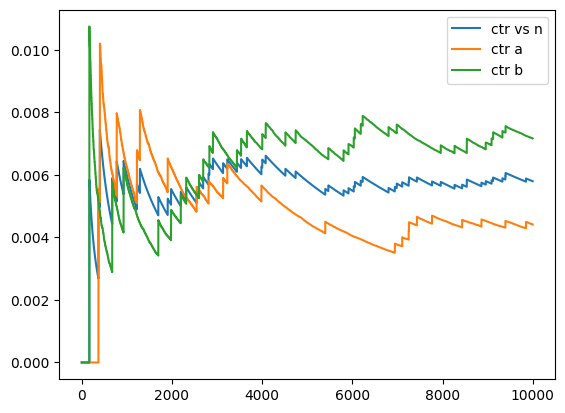

In [77]:
ctr_vs_n, ctr_a, ctr_b = ab_test(10000)
plt.plot(ctr_vs_n, label="ctr vs n")
plt.plot(ctr_a, label="ctr a")
plt.plot(ctr_b, label="ctr b")
plt.legend();

In [78]:
def epsilon_greedy(num_ind, epsilon):
    sum_clicks = 0.0
    num_ads = 0.0
    sum_a, sum_b = 0.0, 0.0
    num_a, num_b = 0, 0
    ctr_vs_n = []
    used_b = []

    for _ in range(num_ind):
        select = "Randomize"
        if np.random.uniform(0, 1) < 1 - epsilon:
            ctr_a = sum_a / num_a if num_a > 0 else 0
            ctr_b = sum_b / num_b if num_b > 0 else 0
            if ctr_a > ctr_b:
                select = "A"
            elif ctr_b > ctr_a:
                select = "B"
        if select == "Randomize":
            if np.random.uniform(0, 1) < 0.5:
                select = "A"
            else:
                select = "B"

        if select == "A":
            clicked = measure_a()
            sum_a += clicked
            num_a += 1
            used_b.append(False)
        else:
            clicked = measure_b()
            sum_b += clicked
            num_b += 1
            used_b.append(True)
        sum_clicks += clicked
        num_ads += 1

        ctr_vs_n.append(sum_clicks / num_ads)
    return ctr_vs_n, used_b

614


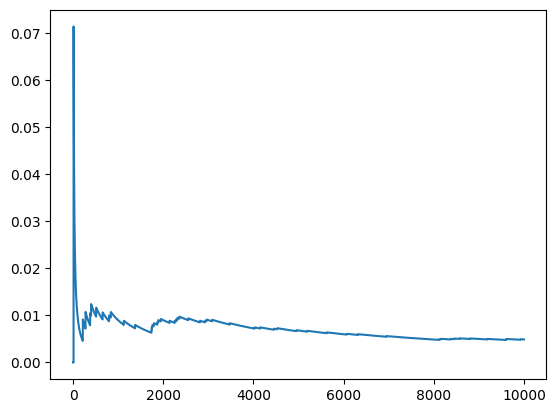

In [79]:
ctr_vs_n, used_b = epsilon_greedy(10000, 0.1)
print(np.sum(used_b))
plt.plot(ctr_vs_n);

In [80]:
def epsilon_greedy_decay():
    bm_max = 0.01
    prac_sig = 0.001
    c = 5

    epsilon_0 = 2 * c * (bm_max / prac_sig) ** 2
    epsilon_stop = 0.01

    sum_clicks = 0.0
    num_ads = 0.0
    sum_a, sum_b = 0.0, 0.0
    num_a, num_b = 0, 0
    ctr_vs_n = []
    epsilons = []

    n = 0
    selected = None
    while True:
        epsilon = min(1.0, epsilon_0 / (1.0 + n))
        epsilons.append(epsilon)
        if epsilon < epsilon_stop:
            break

        select = "Randomize"
        if np.random.uniform(0, 1) < 1 - epsilon:
            ctr_a = sum_a / num_a if num_a > 0 else 0
            ctr_b = sum_b / num_b if num_b > 0 else 0
            if ctr_a > ctr_b:
                select = "A"
                selected = "A"
            elif ctr_b > ctr_a:
                select = "B"
                selected = "B"
        if select == "Randomize":
            if np.random.uniform(0, 1) < 0.5:
                select = "A"
            else:
                select = "B"

        if select == "A":
            clicked = measure_a()
            sum_a += clicked
            num_a += 1
        else:
            clicked = measure_b()
            sum_b += clicked
            num_b += 1
        sum_clicks += clicked
        num_ads += 1

        ctr_vs_n.append(sum_clicks / num_ads)
        n += 1

    if selected == "B":
        accept_reject = "Accept"
    else:
        accept_reject = "Reject"

    return ctr_vs_n, epsilons, accept_reject

Accept


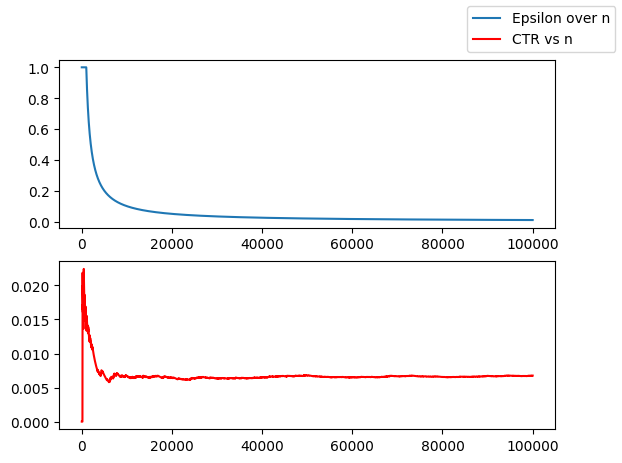

In [81]:
ctr_vs_n, epsilons, accept_reject = epsilon_greedy_decay()
print(accept_reject)
fig, axs = plt.subplots(2, 1)
axs[0].plot(epsilons, label="Epsilon over n")
axs[1].plot(ctr_vs_n, label="CTR vs n", c="red")
fig.legend();

In [82]:
def measure_arm(i_arm):
    return measure_click(ctr=0.005 + i_arm * 0.002)

In [83]:
def epsilon_greedy_decay_multi():
    bm_max = 0.01
    prac_sig = 0.001
    k = 4
    c = 5

    epsilon_0 = k * c * (bm_max / prac_sig) ** 2
    epsilon_stop = 0.01

    sum_clicks = 0.0
    num_ads = 0.0
    sum_arm = [0.0] * k
    num_arm = [0.0] * k
    ctr_vs_n = []

    n = 0
    arms_selected = []
    while True:
        epsilon = min(1.0, epsilon_0 / (1.0 + n))
        if epsilon < epsilon_stop:
            break
        i_selected = None
        if np.random.uniform(0, 1) < 1 - epsilon:
            max_ctr = None
            for i in range(k):
                if num_arm[i] > 0:
                    ctr_arm = sum_arm[i] / num_arm[i]
                else:
                    ctr_arm = 0
                # Break ties by randomizing
                ctr_arm += 1e-9 * np.random.normal()
                if max_ctr is None or ctr_arm > max_ctr:
                    max_ctr = ctr_arm
                    i_selected = i
            i_best_arm = i_selected
        else:
            i_selected = np.random.randint(k)

        arms_selected.append(i_selected)
        clicked = measure_arm(i_selected)
        sum_arm[i_selected] += clicked
        num_arm[i_selected] += 1
        sum_clicks += clicked
        num_ads += 1

        ctr_vs_n.append(sum_clicks / num_ads)
        n += 1

    return ctr_vs_n, arms_selected

Counter({3: 190644, 1: 3656, 2: 2872, 0: 2828})


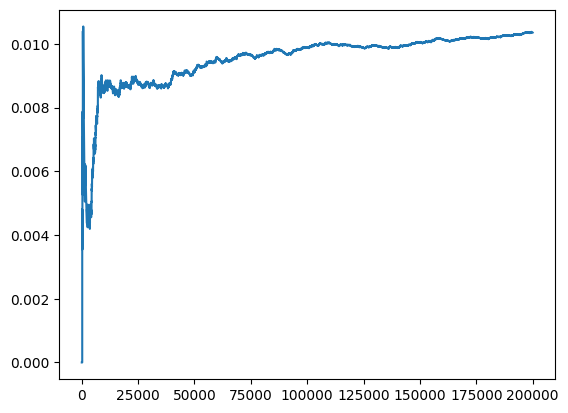

In [84]:
from collections import Counter

ctr_vs_n, arms_selected = epsilon_greedy_decay_multi()
print(Counter(arms_selected))
plt.plot(ctr_vs_n);

## Thompson sampling: A more efficient MAB algorithm

### Bootstrap sampling

Generate a bootstrap sample from a data set

In [85]:
def boostrap_sample(data):
    n = len(data)
    return data[np.random.randint(n, size=(n,))]

In [86]:
np.random.seed(17)

I_clicked = np.array([0, 0, 1, 0, 1, 1, 0, 0, 1, 0])
CTR = I_clicked.mean()
SE = I_clicked.std() / np.sqrt(len(I_clicked))

print(boostrap_sample(I_clicked))
print(boostrap_sample(I_clicked))
print(boostrap_sample(I_clicked))

[0 0 0 0 0 0 1 0 1 0]
[0 0 0 1 1 0 0 0 0 0]
[0 1 0 0 1 0 0 1 0 0]


### Probability of being the best arm

In [87]:
I_clicked_1 = np.array([measure_click(ctr=0.005) for _ in range(10000)])
I_clicked_2 = np.array([measure_click(ctr=0.007) for _ in range(10000)])

In [88]:
def estimate_pbest(I_clicked_1, I_clicked_2):
    counts = [0, 0]
    num_samples = 100
    for _ in range(num_samples):
        ctr_1 = bootstrap_sample(I_clicked_1).mean()
        ctr_2 = bootstrap_sample(I_clicked_2).mean()
        if ctr_1 > ctr_2:
            counts[0] += 1
        elif ctr_2 > ctr_1:
            counts[1] += 1
        else:
            pass
    p_best = np.array(counts) / num_samples
    return p_best

### Estimate the probability that each arm is best

In [89]:
def estimate_pbest(I_clickeds):
    counts = [0] * len(I_clickeds)
    num_samples = 100

    for _ in range(num_samples):
        ctrs = [boostrap_sample(I_clicked).mean() for I_clicked in I_clickeds]
        ctrs = np.array(ctrs)
        i = np.where(ctrs == ctrs.max())[0]
        if len(i) == 1:
            counts[i[0]] += 1

    return np.array(counts) / num_samples

In [90]:
np.random.seed(17)
I_clickeds = [None] * 4
I_clickeds[0] = np.array([measure_click(ctr=0.003) for _ in range(10000)])
I_clickeds[1] = np.array([measure_click(ctr=0.005) for _ in range(10000)])
I_clickeds[2] = np.array([measure_click(ctr=0.007) for _ in range(10000)])
I_clickeds[3] = np.array([measure_click(ctr=0.009) for _ in range(10000)])
estimate_pbest(I_clickeds)

array([0.  , 0.  , 0.04, 0.94])

### Randomized probability matching

In [91]:
def rpm_select_arm(I_clickeds):
    ctrs = [boostrap_sample(I_clicked).mean() for I_clicked in I_clickeds]
    ctrs = np.array(ctrs)
    i = np.where(ctrs == ctrs.max())[0]
    if len(i) != i:
        return np.random.randint(len(I_clickeds))

    return i[0]

### Online Boostrap

In [92]:
class OnlineBoostrap:
    def __init__(self, num_bs_means):
        # Track number of bootstrap means for a single arm.
        self._sums = np.zeros(shape=(num_bs_means,))
        self._n = np.zeros(shape=(num_bs_means,))
        self._count = 0

    def append(self, clicked):
        i = np.where(np.random.randint(2, size=(len(self._n))) == 0)[0]
        self._sums[i] += clicked
        self._n[i] += 1
        self._count += 1

    def CTR_estimate(self):
        i = np.random.randint(len(self._n))
        if self._n[i] == 0:
            return np.inf
        return self._sums[i] / self._n[i]

    def count(self):
        return self._count

### Randomized probability matching with the online bootstrap

In [93]:
def rpm_select_arm_ob(obs):
    ctrs = [ob.CTR_estimate() for ob in obs]
    ctrs = np.array(ctrs)
    i = np.where(ctrs == ctrs.max())[0]
    return np.random.choice(i)

## Estimate pbest with the online boostrap

In [94]:
def estimate_pbest_ob(obs):
    counts = [0] * len(obs)
    num_samples = 100
    for _ in range(num_samples):
        ctrs = [ob.CTR_estimate() for ob in obs]
        ctrs = np.array(ctrs)
        i = np.where(ctrs == ctrs.max())[0]
        if len(i) == 1:
            counts[i[0]] += 1

    return np.array(counts) / num_samples

### Thompson sampling

In [95]:
def thompson_sampling():
    k = 4
    num_bs_means = 100

    # Stop when the probability of an arm being the best has reached 0.95
    p_stop = 0.95
    smallest_sum_difference = 1
    prac_sig = 0.001

    min_samples_per_arm = smallest_sum_difference / prac_sig
    obs = [OnlineBoostrap(num_bs_means) for _ in range(k)]
    sum_clicks = 0.0
    num_ads = 0.0
    ctr_vs_n = []

    n = 0
    while True:
        num_samples_per_arm = [ob.count() for ob in obs]
        i_too_few = np.where(np.array(num_samples_per_arm) < min_samples_per_arm)[0]
        if len(i_too_few) > 0:
            i_selected = np.random.choice(i_too_few)
        else:
            i_selected = rpm_select_arm_ob(obs)
        i_clicked = measure_arm(i_selected)
        obs[i_selected].append(i_clicked)
        sum_clicks += i_clicked
        num_ads += 1
        ctr_vs_n.append(sum_clicks / num_ads)

        n += 1

        if len(i_too_few) == 0 and n % 100 == 0:
            p_bests = estimate_pbest_ob(obs)
            i_best_arm = np.where(p_bests == p_bests.max())[0]
            if len(i_best_arm) == 1 and p_bests.max() >= p_stop:
                break

    return ctr_vs_n, i_best_arm

[3]


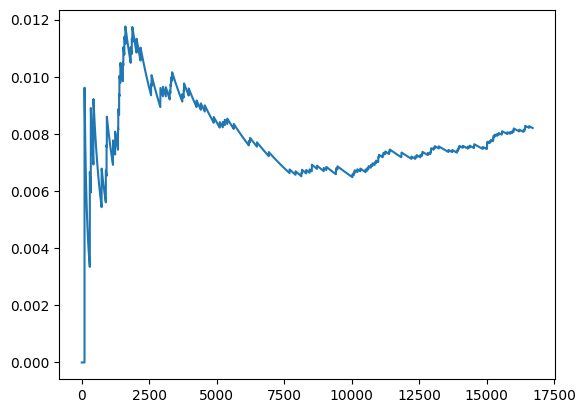

In [96]:
ctr_vs_n, i_best_arm = thompson_sampling()
print(i_best_arm)
plt.plot(ctr_vs_n);